<a href="https://colab.research.google.com/github/AhmedAsaad272/CNN_classigication-with-Fashion-MNIST/blob/main/Quiz3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
# mount drive so that we can save the model to google drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = '/content/drive/My Drive/'

In [ ]:
#transforming the PIL Image to tensors
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

In [149]:
train_data_size=6000
valid_data_size=1000
test_data_size=1000
#loading the training data from trainset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle = True)
#loading the test data from testset
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

In [150]:
a=len(testloader)
a

1000

In [151]:
# define our convolutional neural networks
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        torch.nn.init.xavier_uniform_(self.conv1.weight)

        self.conv2 = nn.Conv2d(6, 12, 5)
        torch.nn.init.xavier_uniform_(self.conv2.weight)


        self.pool = nn.MaxPool2d(2,2) # kernel size 2x2, stride = 2

        n_size = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(n_size, 192)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(192, 120)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(120, 60)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        self.fc4 = nn.Linear(60,10)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

        self.dropout = nn.Dropout(0.3)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        return x
      
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # flattening
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))        
        x = self.fc4(x)
        return x

In [152]:
input_size = (1,28,28)
num_classes=(10)
model = Net(input_size , num_classes)
model = model.to('cuda:0')

In [153]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [154]:
# Define Optimizer and Loss Function
learning_rate = 0.1
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [155]:
def train_and_validate(model, loss_criterion, optimizer, epochs=50):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=10)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, data in enumerate(trainloader):

            inputs, labels = data
            #moving the input and labels to gpu
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, data in enumerate(testloader):
                inputs, labels = data
                #moving the input and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 10 epochs
num_epochs = 50
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/50
Epoch : 000, Training: Loss: 23.3794, Accuracy: 104.5500%, 
		Validation : Loss : 23.1679, Accuracy: 100.0000%, Time: 22.8281s
Epoch: 2/50
Epoch : 001, Training: Loss: 23.2519, Accuracy: 99.9500%, 
		Validation : Loss : 23.2034, Accuracy: 100.0000%, Time: 23.4262s
Epoch: 3/50
Epoch : 002, Training: Loss: 23.2650, Accuracy: 99.6500%, 
		Validation : Loss : 23.3678, Accuracy: 100.0000%, Time: 23.5069s
Epoch: 4/50
Epoch : 003, Training: Loss: 23.2627, Accuracy: 99.4333%, 
		Validation : Loss : 23.1521, Accuracy: 100.0000%, Time: 23.4101s
Epoch: 5/50
Epoch : 004, Training: Loss: 23.2561, Accuracy: 101.0667%, 
		Validation : Loss : 23.2206, Accuracy: 100.0000%, Time: 23.4529s
Epoch: 6/50
Epoch : 005, Training: Loss: 23.2574, Accuracy: 99.9167%, 
		Validation : Loss : 23.2027, Accuracy: 100.0000%, Time: 22.7672s
Epoch: 7/50
Epoch : 006, Training: Loss: 23.2494, Accuracy: 100.1167%, 
		Validation : Loss : 23.5566, Accuracy: 100.0000%, Time: 22.8785s
Epoch: 8/50
Epoch : 007, Traini

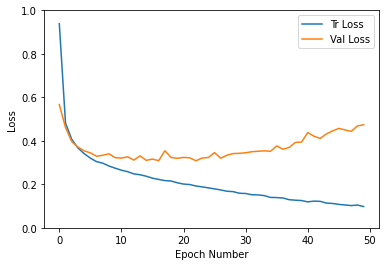

In [108]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

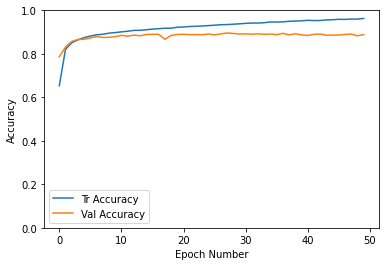

In [109]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()